In [1]:
from pathlib import Path
import sys
import yaml
import time
import os
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines
from geopy.geocoders import GoogleV3, Nominatim

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer

import warnings
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"
START_TIME = "07:00:00"
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 10

background_path = os.path.join('..', 'data', 'plot', 'background')
city = gpd.read_file(os.path.join(background_path, "madison-meter-shp")).to_crs(4326)
lakes = gpd.read_file(os.path.join(background_path, "water-meter-shp")).to_crs(4326)
street = gpd.read_file(os.path.join(background_path, "street-meter-shp")).to_crs(4326)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

In [3]:
def get_yelp_api_key():
    with open("../config.yml", 'r') as yml:
        cfg = yaml.safe_load(yml)
        return cfg["yelp"]["api_key"]

def plot_background(crs):
    background_path = os.path.join('..', 'data', 'plot', 'background')
    city = gpd.read_file(os.path.join(background_path, "madison-meter-shp")).to_crs(crs)
    lakes = gpd.read_file(os.path.join(background_path, "water-meter-shp")).to_crs(crs)
    street = gpd.read_file(os.path.join(background_path, "street-meter-shp")).to_crs(crs)
    # city = gpd.read_file(background_path + "madison-shp")
    # lakes = gpd.read_file(background_path + "water-shp")
    # street = gpd.read_file(background_path + "street-shp")

    ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
    lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=0.8)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    return ax

cache = {}
def geocode(addr):
    if not "madison" in addr.lower():
        addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

In [4]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


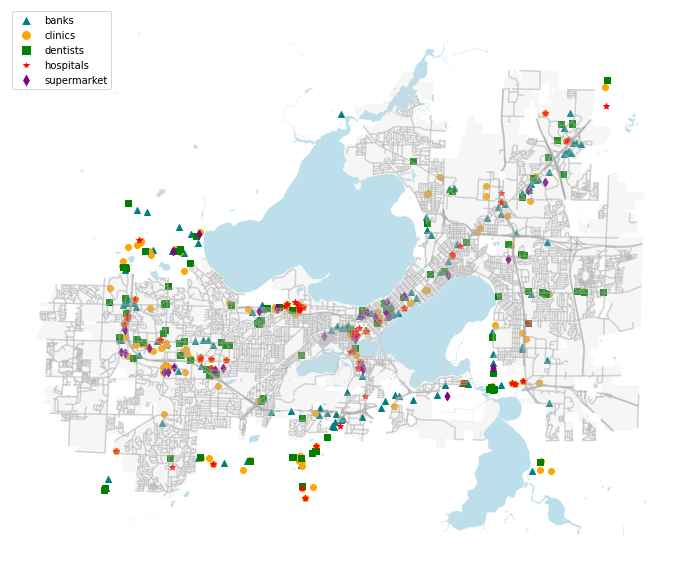

In [5]:
temp_df = services_gdf.apply(copy.deepcopy)

ax = plot_background(f"EPSG:{gtfo.epsg}")

epsg = findEPSG(temp_df['latitude'][0], temp_df['longitude'][0])
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y
temp_df = temp_df[(temp_df['latitude'] < max_lat) & (temp_df['latitude'] > min_lat) & (temp_df['longitude'] < max_lon) & (temp_df['longitude'] > min_lon)]
banks = temp_df[temp_df['service'] == 'banks']
clinics = temp_df[temp_df['service'] == 'clinics']
dentists = temp_df[temp_df['service'] == 'dentists']
hospitals = temp_df[temp_df['service'] == 'hospitals']
supermarket = temp_df[temp_df['service'] == 'supermarket']
banks = gpd.GeoDataFrame(
    banks['service'], geometry=gpd.points_from_xy(banks.stop_x, banks.stop_y), crs="EPSG:"+str(epsg))
clinics = gpd.GeoDataFrame(
    clinics['service'], geometry=gpd.points_from_xy(clinics.stop_x, clinics.stop_y), crs="EPSG:"+str(epsg))
dentists = gpd.GeoDataFrame(
    dentists['service'], geometry=gpd.points_from_xy(dentists.stop_x, dentists.stop_y), crs="EPSG:"+str(epsg))
hospitals = gpd.GeoDataFrame(
    hospitals['service'], geometry=gpd.points_from_xy(hospitals.stop_x, hospitals.stop_y), crs="EPSG:"+str(epsg))
supermarket = gpd.GeoDataFrame(
    supermarket['service'], geometry=gpd.points_from_xy(supermarket.stop_x, supermarket.stop_y), crs="EPSG:"+str(epsg))
banks.plot(ax=ax, color='teal', marker='^')
clinics.plot(ax=ax, color='orange', marker='o')
dentists.plot(ax=ax, color='green', marker='s')
hospitals.plot(ax=ax, color='red', marker='*')
supermarket.plot(ax=ax, color='purple', marker='d')

lineslist = []
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "teal", marker = "^", markersize=10, label = "banks"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "orange", marker = "o", markersize=10, label = "clinics"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "green", marker = "s", markersize=10, label = "dentists"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "red", marker = "*", markersize=10, label = "hospitals"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "purple", marker = "d", markersize=10, label = "supermarket"))
ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()

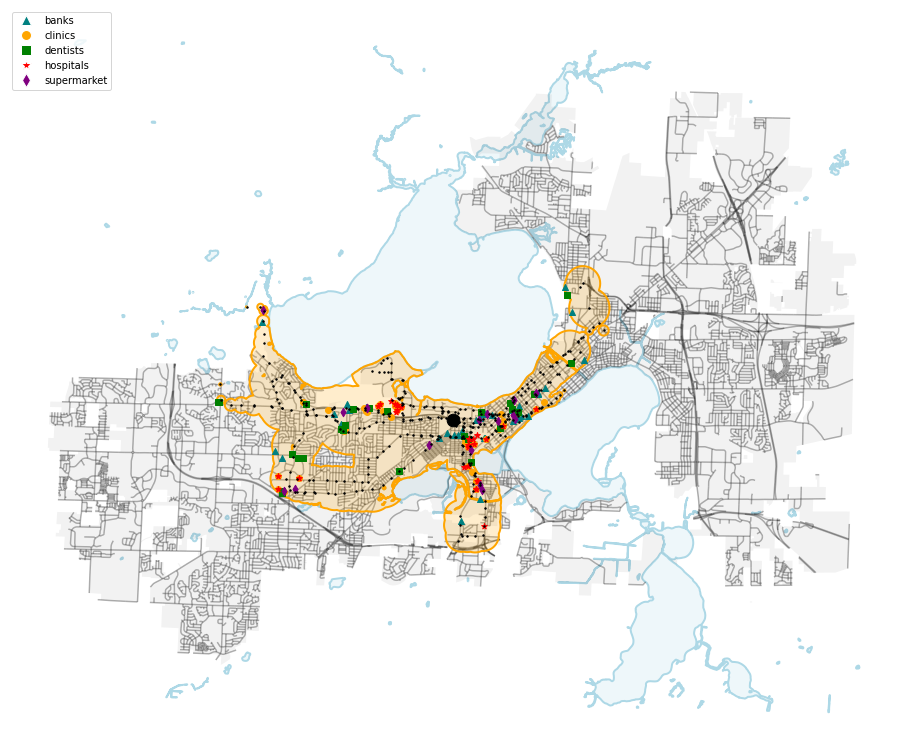

In [6]:
city = city.to_crs(epsg)
lakes = lakes.to_crs(epsg)
street = street.to_crs(epsg)
ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
city.plot(color="black", alpha=0.05, ax=ax, zorder=2)
street.plot(color="black", alpha=0.3, ax=ax, zorder=3)

colors = ["orange", "blue", "green", "yellow"]

zorder = 4
addr = '330 N Orchard St'

location = geocode(addr)
lat, lon = (location.latitude, location.longitude)

gdf = busSim.get_gdf(start_point=(lat, lon)) # bubble
gdf = gdf.to_crs(epsg=epsg)

color = colors[0]
bubble = flatten(gdf.difference(lakes.unary_union)) # the difference between bubble and lakes = bubble - lakes
bubble["color"] = color
bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
# Round-trip the data through a flat projection, ideally one which preserves area, such as Equal Area Cylindrical ('+proj=cea')
gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+4)
start = gpd.GeoSeries([Point(lon, lat)], crs=4326)
start = start.to_crs(epsg)
start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100) # draw start point

df = bubble
df.plot(alpha=0.2, ax=ax, color=df["color"], zorder=zorder) # plot bubble

bubble = bubble.loc[0, 'geometry']
banks_limit = banks.intersection(bubble)
banks_limit = gpd.GeoSeries(banks_limit, crs=epsg)
banks_limit.plot(ax=ax, color='teal', marker='^', zorder=zorder+3)

clinics_limit = clinics.intersection(bubble)
clinics_limit = gpd.GeoSeries(clinics_limit, crs=epsg)
clinics_limit.plot(ax=ax, color='orange', marker='o', zorder=zorder+3)

dentists_limit = dentists.intersection(bubble)
dentists_limit = gpd.GeoSeries(dentists_limit, crs=epsg)
dentists_limit.plot(ax=ax, color='green', marker='s', zorder=zorder+3)

hospitals_limit = hospitals.intersection(bubble)
hospitals_limit = gpd.GeoSeries(hospitals_limit, crs=epsg)
hospitals_limit.plot(ax=ax, color='red', marker='*', zorder=zorder+3)

supermarket_limit = supermarket.intersection(bubble)
supermarket_limit = gpd.GeoSeries(supermarket_limit, crs=epsg)
supermarket_limit.plot(ax=ax, color='purple', marker='d', zorder=zorder+3)

ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})
# leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
# leg.get_frame().set_facecolor("white")
# leg.get_frame().set_edgecolor("white")

ax.set_axis_off() # set axis off